In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
# !pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install tifffile

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mjsqtpg8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mjsqtpg8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=efcd98af652f5f17166d475664dfd4afcc1c959029d583011f953ce5a1fd6e3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqkwrxtz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/11

In [3]:
import numpy as np
import os
import random

import tifffile
import matplotlib.pyplot as plt
from patchify import patchify
from scipy import ndimage

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from transformers import SamModel, SamConfig, SamProcessor

# Begin

In [4]:
def load_model(model_config,processor,checkpoint_path,device):
  # model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
  # processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
  # Create an instance of the model architecture with the loaded configuration
  sidewalk_model = SamModel(config=model_config)
  checkpoint = torch.load(checkpoint_path)
  sidewalk_model.load_state_dict(checkpoint['model_state'])
  # device = "cuda" if torch.cuda.is_available() else "cpu"
  sidewalk_model.to(device)
  return sidewalk_model

In [5]:
from transformers import SamModel, SamConfig, SamProcessor

def SidewalkPlain(sidewalk_model,processor,image_np,prompt_boxes,threshold):
  if prompt_boxes is not None:
    input_boxes=[[prompt_boxes]]
    inputs = processor(image_np, input_boxes=input_boxes,return_tensors="pt")
  else:
    inputs = processor(image_np, return_tensors="pt")
  inputs = {k: v.to(device) for k, v in inputs.items()}
  sidewalk_model.eval()

  with torch.no_grad():
    outputs = sidewalk_model(**inputs, multimask_output=False)

  prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  seg_prob = prob.cpu().numpy().squeeze()
  mask= (seg_prob > threshold).astype(np.uint8)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(np.array(image_np), cmap='gray')  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(mask, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Prediction without Point Prompt")

  # Plot the second image on the right
  axes[2].imshow(seg_prob)  # Assuming the second image is grayscale
  axes[2].set_title("Probability Map without Point Prompt")
  for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


  return mask


In [6]:
from transformers import SamModel, SamConfig, SamProcessor

def SidewalkPrompter(sidewalk_model,processor,image_np,prompt_points,prompt_points_labels,prompt_boxes,threshold):
  """
  - SAM_model:
  - image_np:
  - prompt_points: points visual prompt in one mask in format of [[x1,y1],[x2,y2],[x3,y3],..,[xn,yn]]
  - prompt_points_labels : labels for prompt_points --> 1: forground 0:background
  - prompt_boxes: area of interest in bbox format : [x_left,y_top,x_right,y_buttom]
  - threshold: confidence of the masks
  """
  input_points=[prompt_points]
  input_labels=[prompt_points_labels]
  # input_boxes=[[prompt_boxes]]
  if prompt_boxes is not None:
    input_boxes=[[prompt_boxes]]
    inputs = processor(image_np, input_boxes=input_boxes,input_points=input_points,input_labels=input_labels,return_tensors="pt")
  else:
    inputs = processor(image_np,input_points=input_points,input_labels=input_labels,return_tensors="pt")

  device = "cuda" if torch.cuda.is_available() else "cpu"
  inputs = {k: v.to(device) for k, v in inputs.items()}
  sidewalk_model.eval()
  with torch.no_grad():
    outputs = sidewalk_model(**inputs, multimask_output=False)

    # apply sigmoid
  prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  seg_prob = prob.cpu().numpy().squeeze()
  mask= (seg_prob > threshold).astype(np.uint8)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(np.array(image_np), cmap='gray')  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(mask, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Prediction with Point Prompt")

  # Plot the second image on the right
  axes[2].imshow(seg_prob)  # Assuming the second image is grayscale
  axes[2].set_title("Probability Map with Point Prompt")

  for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

  return mask

In [7]:
from PIL import Image
import cv2

def preprocess(image_path):
  """
  Make sure the image is a numpy array of size (256,256)
  """
  image= np.array(Image.open(image_path))
  image_resize=cv2.resize(image, (256, 256))
  return image_resize

In [8]:
import plotly.express as px
from PIL import Image
def prompt_select(image_np):
  """
  - image_np: image in numpy array format
  """
  fig = px.imshow(image_np)
  fig.update_layout(clickmode='event+select')
  clicked_points = []

  def on_click(trace, points, state):
      if points.point_inds:
          for i in points.point_inds:
              coord = (points.xs[i], points.ys[i])
              clicked_points.append(coord)

  fig.data[0].on_click(on_click)
  fig.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visual_prompt_display(image_np, input_points, input_labels, input_boxes=None):
    """
    Display the visual prompt in the image
    image_np: numpy array of image after preprocess
    input_points: The list of visual prompt points
    input_labels: The list of labels of visual prompt points -- 1: foreground points in color yellow, 0/-1: background points in color blue
    input_boxes: area of interest in bbox format : [x_left,y_top,x_right,y_buttom]
    """
    points = np.array(input_points)
    labels = input_labels

    fig, ax = plt.subplots()
    ax.imshow(image_np)

    for i, (x, y) in enumerate(points):
        label = labels[i]
        color = 'yellow' if label == 1 else 'blue'
        ax.plot(x, y, '*', color=color, markersize=8)

    if input_boxes is not None:
        width = input_boxes[2] - input_boxes[0]
        height = input_boxes[3] - input_boxes[1]
        rect = patches.Rectangle((input_boxes[0], input_boxes[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.axis("off")
    ax.set_title('Visualizing Prompting on Image')

    # return image_from_plot


In [10]:
def overlay_mask(image,mask,show=True):
  overlay = np.zeros_like(image)
  # color = np.array([0,200,255], dtype=np.uint8)
  color = np.array([255,215,0], dtype=np.uint8)
  overlay[mask == 1] =color
  alpha = 0.5
  combined = cv2.addWeighted(image, 1, overlay,alpha , 0)
  if show:
    plt.figure(figsize=(5,5))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()
  return combined

In [11]:
## load the model
checkpoint_path="/content/drive/MyDrive/SAM/checkpoint.pth_1"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
SAM_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sidewalk_model=load_model(model_config,SAM_processor,checkpoint_path,device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [12]:
img_path="/content/val_1.tif"
image=preprocess(img_path)
prompt_select(image)

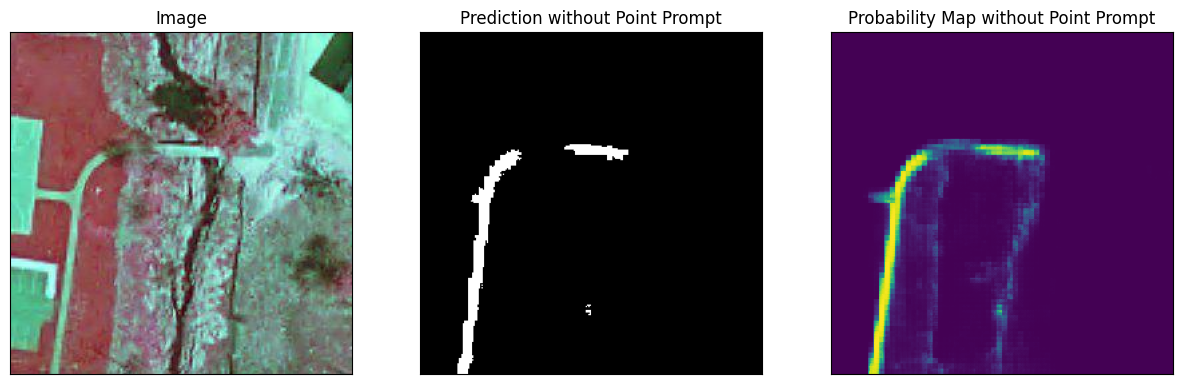

In [13]:
thre=0.5
input_boxes=[25,81,162,256]
mask_plain=SidewalkPlain(sidewalk_model,SAM_processor,image,input_boxes,threshold=thre)

In [14]:
prompt_select(image)

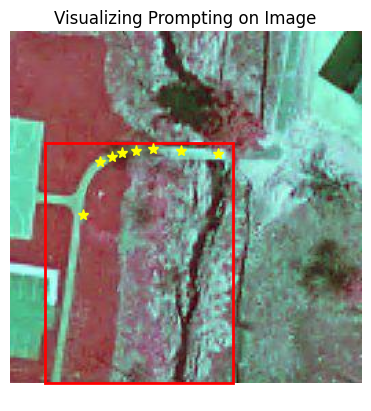

In [15]:
input_points=[[53,133], [65,95],[74,91], [81,88],[91,87],[104,85],[124,87],[151,89]]
# input_points=[[55,61], [50,98],[45,170], [39,190],[46,121]]130,218
input_labels = [1, 1, 1, 1,1,1,1,1]
input_boxes=input_boxes

visual_prompt_display(image,input_points,input_labels,input_boxes=input_boxes)

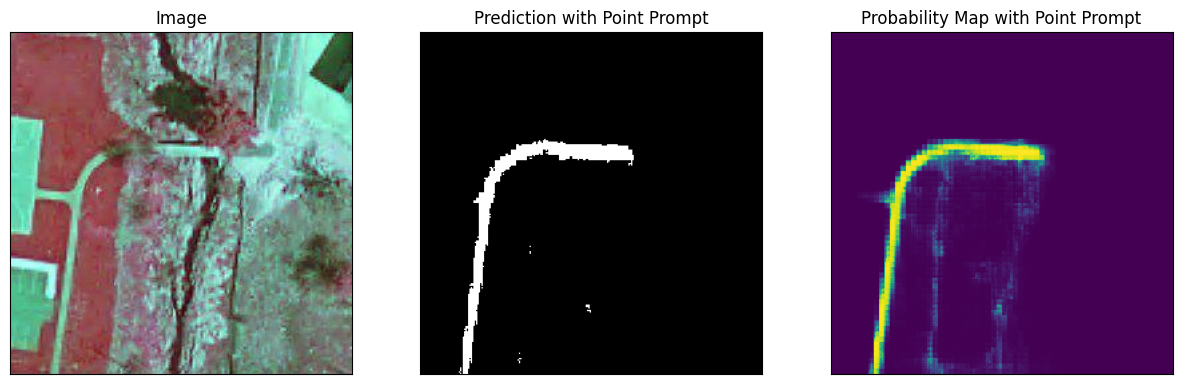

In [16]:
thre=0.5
mask_prompt=SidewalkPrompter(sidewalk_model,SAM_processor,image,prompt_points=input_points,prompt_points_labels=input_labels,prompt_boxes=input_boxes,threshold=thre)

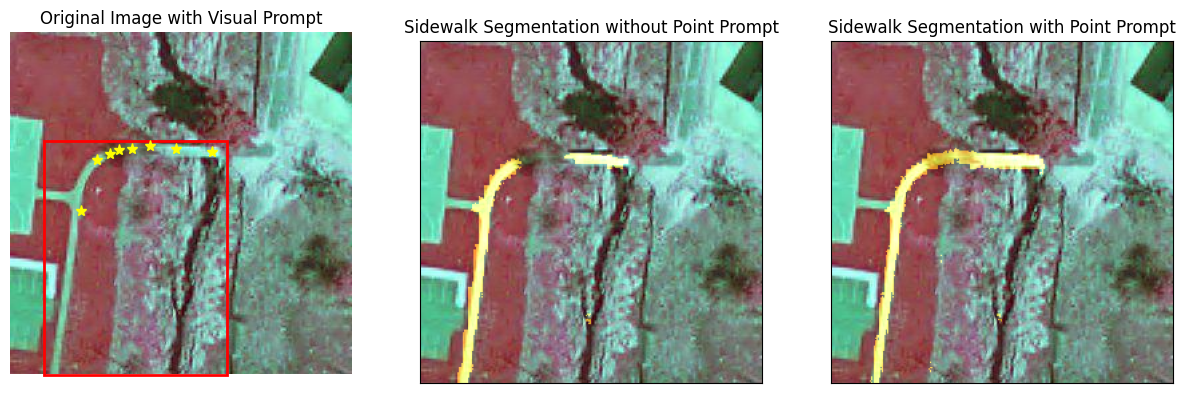

In [17]:
seg_plain=overlay_mask(image,mask_plain,show=False)
seg_prompt=overlay_mask(image,mask_prompt,show=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)  # Assuming the first image is grayscale
for i, (x, y) in enumerate(input_points):
    label = input_labels[i]
    color = 'yellow' if label == 1 else 'blue'
    axes[0].plot(x, y, '*', color=color, markersize=8)

if input_boxes is not None:
    width = input_boxes[2] - input_boxes[0]
    height = input_boxes[3] - input_boxes[1]
    rect = patches.Rectangle((input_boxes[0], input_boxes[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)

axes[0].set_title("Original Image with Visual Prompt")
axes[0].axis("off")

axes[1].imshow(seg_plain)  # Assuming the first image is grayscale
axes[1].set_title("Sidewalk Segmentation without Point Prompt")

# Plot the second image on the right
axes[2].imshow(seg_prompt)  # Assuming the second image is grayscale
axes[2].set_title("Sidewalk Segmentation with Point Prompt")

for ax in axes:
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

# plt.suptitle('Sidewalk Segmentation')

plt.show()
